In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd

from scipy.io import loadmat

import seaborn as sns

from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, Conv1D, Flatten, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.backend as K

import scipy.stats as stats
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import plotly.express as px

In [2]:
tf.config.experimental.list_physical_devices()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# domain adaptation task
# Task 0 −→ 1 means working load 0 is the source domain with labeled training samples, and
# working load 1 is the target domain we want to improve model performance on.
src = 3
tgt = 2

In [4]:
orrd = pd.DataFrame([
        ['100', 3, 0],
        ['108', 3, 1],
        ['172', 3, 2],
        ['212', 3, 3],
        ['133', 3, 4],
        ['200', 3, 5],
        ['237', 3, 6],
        ['121', 3, 7],
        ['188', 3, 8],
        ['225', 3, 9],
                                  
        ['099', 2, 0],
        ['107', 2, 1],
        ['171', 2, 2],
        ['211', 2, 3],
        ['132', 2, 4],
        ['199', 2, 5],
        ['236', 2, 6],
        ['120', 2, 7],
        ['187', 2, 8],
        ['224', 2, 9],
        
        ['098', 1, 0],
        ['106', 1, 1],
        ['170', 1, 2],
        ['210', 1, 3],
        ['131', 1, 4],
        ['198', 1, 5],
        ['235', 1, 6],
        ['119', 1, 7],
        ['186', 1, 8],
        ['223', 1, 9],
        
        ['097', 0, 0],
        ['105', 0, 1],
        ['169', 0, 2],
        ['209', 0, 3],
        ['130', 0, 4],
        ['197', 0, 5],
        ['234', 0, 6],
        ['118', 0, 7],
        ['185', 0, 8],
        ['222', 0, 9]], columns = ['name','load','label'])

In [5]:
# returns data and labels
def cwru_data(load, percentage, truncate=120000, length=1024, sample=200, shuffle=False):
    out = []
    data_out = []
    lbls = []

    for ii in orrd[orrd['load']==load]['name'].index:
    # loading the .mat - lbl can be [0,1,2,3,4,5,6,7,8,9] when percentage="all" 
    # or [0,1] when percentage="20%"
        
        lbl = orrd.iloc[ii]['label']
        file_number = orrd.iloc[ii]['name']
#         print(file_number)
        file_dirs = 'C:/Users/lucas/Documents/Doutorado/WorkSpace/DADOS CWRU/01_Raw/' + file_number + '.mat'
        data = loadmat(file_dirs)
        for i in data:
            # taking only the DE list of values
            if "X{}_DE_time".format(file_number) == i:
#                 print("OK!")
#                 print(i)
#                 for j in range(0, len(data) - length + 1 , (len(data) - length)//(sample - 1) ):
#                     print(j)
                if file_number in ['097', '098', '099', '100']:
                    print('filtro', file_number)
                    data[i] = data[i][1::4]
                data = data[i][:truncate] # truncating the length of data
                data = [data[j:j + length] for j in range(0, len(data) - length + 1 , (len(data) - length)//(sample - 1) )] # sampling
                #data = np.lib.stride_tricks.sliding_window_view(data.reshape(truncate),1024)[::1024, :]
                    
                # carrying out fft
                for k in range(0,len(data)):
                    data_out.append(data[k])
                    fft = abs(np.fft.fft(data[k])[:len(data[k])//2])
                    out.append(fft)
                    lbls.append([lbl])
            else:
                pass

    # one hot encoding
    #lbls = to_categorical(np.array(lbls))

    return data_out, np.array(out), np.array(lbls)

In [6]:
# preparing data for stage 1
data, data_fft, labels = cwru_data(load=src, percentage="full", shuffle=True)
data_tgt, data_fft_tgt, labels_tgt = cwru_data(load=tgt, percentage="full", shuffle=True)

data_src = np.array(data).reshape(2000,1024)
data_src = data_src
label_src = np.array(labels).reshape(2000)

data_tgt = np.array(data_tgt).reshape(2000,1024)
data_tgt = data_tgt
label_tgt = np.array(labels_tgt).reshape(2000)

print("Source dimension", data_src.shape, label_src.shape)
print("Target dimension", data_tgt.shape, label_tgt.shape)

filtro 100
filtro 099
Source dimension (2000, 1024) (2000,)
Target dimension (2000, 1024) (2000,)


In [7]:
fft = lambda sig: abs(np.fft.fft(sig)[0:len(sig)//2])/len(sig)
#fft = lambda sig: abs(np.fft.fft(sig)[0:len(sig)//2])

data_src_fft = np.array([fft(sig) for sig in data_src])
data_src_fft[1:] = data_src_fft[1:]*2

data_tgt_fft = np.array([fft(sig) for sig in data_tgt])
data_tgt_fft[1:] = data_tgt_fft[1:]*2

print("Source dimension", data_src_fft.shape, label_src.shape)
print("Target dimension", data_tgt_fft.shape, label_tgt.shape)

Source dimension (2000, 512) (2000,)
Target dimension (2000, 512) (2000,)


In [8]:
### Expand the last dimension for ease of feeding conv1d
data_src = np.expand_dims(data_src, axis=-1)
data_src_fft = np.expand_dims(data_src_fft, axis=-1)
data_tgt = np.expand_dims(data_tgt, axis=-1)
data_tgt_fft = np.expand_dims(data_tgt_fft, axis=-1)
print("Source dimension", data_src_fft.shape, data_src.shape)
print("Target dimension", data_tgt_fft.shape, data_tgt.shape)

Source dimension (2000, 512, 1) (2000, 1024, 1)
Target dimension (2000, 512, 1) (2000, 1024, 1)


In [9]:
fs = 12000
N = 1024
tend = N/fs
dt = tend/N
print('df = {}'.format(1/tend))
t = np.array(range(0,N))*dt
print(t)

f = np.array(range(0,N//2))*fs/N

print(f)

df = 11.71875
[0.00000000e+00 8.33333333e-05 1.66666667e-04 ... 8.50833333e-02
 8.51666667e-02 8.52500000e-02]
[   0.        11.71875   23.4375    35.15625   46.875     58.59375
   70.3125    82.03125   93.75     105.46875  117.1875   128.90625
  140.625    152.34375  164.0625   175.78125  187.5      199.21875
  210.9375   222.65625  234.375    246.09375  257.8125   269.53125
  281.25     292.96875  304.6875   316.40625  328.125    339.84375
  351.5625   363.28125  375.       386.71875  398.4375   410.15625
  421.875    433.59375  445.3125   457.03125  468.75     480.46875
  492.1875   503.90625  515.625    527.34375  539.0625   550.78125
  562.5      574.21875  585.9375   597.65625  609.375    621.09375
  632.8125   644.53125  656.25     667.96875  679.6875   691.40625
  703.125    714.84375  726.5625   738.28125  750.       761.71875
  773.4375   785.15625  796.875    808.59375  820.3125   832.03125
  843.75     855.46875  867.1875   878.90625  890.625    902.34375
  914.0625   925.7

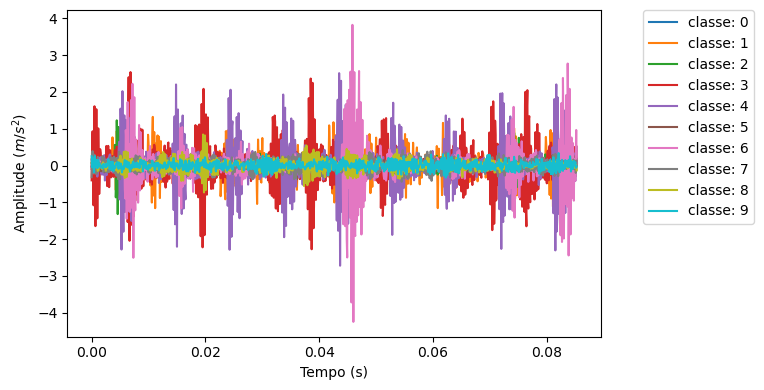

In [10]:
# Have a taste of data, the given target data is in order..
plt.figure(figsize=(8, 4))
for i in range(10):
    plt.plot(t, data_tgt[200*i], label="classe: " + str(i))
    assert(label_tgt[200*i] == i)
plt.legend(loc = 'upper right',
          bbox_to_anchor=(1.3, 1.02))
plt.xlabel('Tempo (s)')
plt.ylabel("Amplitude ($m/s^2$)")
plt.tight_layout()
plt.savefig('./imagens/C{}_todos as classes amosta no tempo.jpg'.format(tgt), dpi = 600)

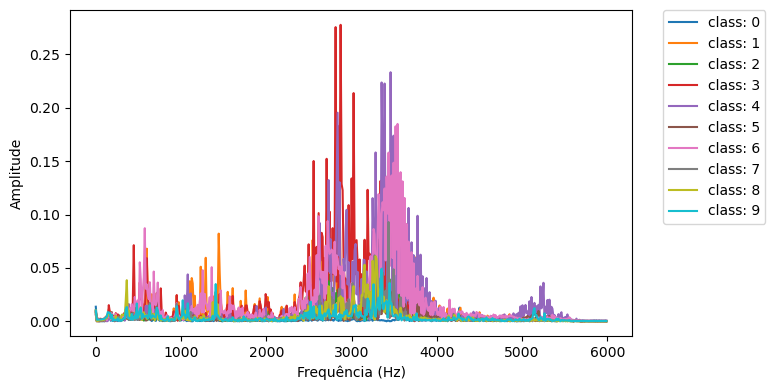

In [11]:
plt.figure(figsize=(8, 4))
for i in range(10):
    plt.plot(f, data_tgt_fft[200*i], label="class: " + str(i))
    assert(label_tgt[200*i] == i)
plt.legend(loc = 'upper right',
          bbox_to_anchor=(1.25, 1.02))
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.savefig('./imagens/C{}_todos as classes amosta frequencia.jpg'.format(tgt), dpi = 600)

# PCA Plotting 

In [12]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [13]:
pca = PCA(n_components=7)
pca_model = pca.fit(data_src_fft.reshape(2000,512))
Xfactor_train_source = pca_model.transform(data_src_fft.reshape(2000,512))
Xfactor_train_target = pca_model.transform(data_tgt_fft.reshape(2000,512))

In [14]:
Xfactor_source = pd.DataFrame(Xfactor_train_source).reset_index(drop=True)
Xfactor_target = pd.DataFrame(Xfactor_train_target).reset_index(drop=True)
y_train_source = pd.DataFrame(label_src).reset_index(drop=True)
y_train_source['Condition']='Source'
Xfactor_source[['Classe', 'Condition']]= y_train_source
y_train_target = pd.DataFrame(label_tgt).reset_index(drop=True)
y_train_target['Condition']='Target'
Xfactor_target[['Classe', 'Condition']]= y_train_target

In [15]:
Xfactor_train_global = pd.concat([Xfactor_source, Xfactor_target])
Xfactor_train_global.reset_index(inplace=True, drop=True)
Xfactor_train_global

0         1         2         3         4         5         6  \
0    -0.264842 -0.037718  0.025039  0.016575  0.005917  0.005334  0.015327   
1    -0.248014 -0.039053  0.014940  0.010190  0.004457  0.006674  0.018542   
2    -0.248469 -0.040581  0.015503  0.007539  0.003414  0.006554  0.019677   
3    -0.245504 -0.041565  0.016122  0.006293  0.004506  0.006794  0.019796   
4    -0.250163 -0.039243  0.016691  0.010510  0.004863  0.004037  0.019869   
...        ...       ...       ...       ...       ...       ...       ...   
3995 -0.191979 -0.026033  0.021559  0.039156 -0.001550  0.008951 -0.003286   
3996 -0.188620 -0.027581  0.018340  0.044859  0.005407  0.022290  0.005641   
3997 -0.191734 -0.018441  0.021796  0.037436  0.008880 -0.001454 -0.015105   
3998 -0.179791 -0.027908  0.021178  0.045744 -0.005179  0.028222  0.006994   
3999 -0.185228 -0.022486  0.025595  0.043210  0.006703  0.016396 -0.008587   

      Classe Condition  
0          0    Source  
1          0    Source  
2          0    Source  
3          0    Source  
4          0    Source  
...      ...       ...  
3995       9    Target  
3996       9    Target  
3997       9    Target  
3998       9    Target  
3999       9    Target  

[4000 rows x 9 columns]

In [16]:
print(
    "explained variance ratio (first two components): %s"
    % str(pca_model.explained_variance_ratio_)
)

explained variance ratio (first two components): [0.48439084 0.14336911 0.08676275 0.05024138 0.0249424  0.01746476
 0.01312074]


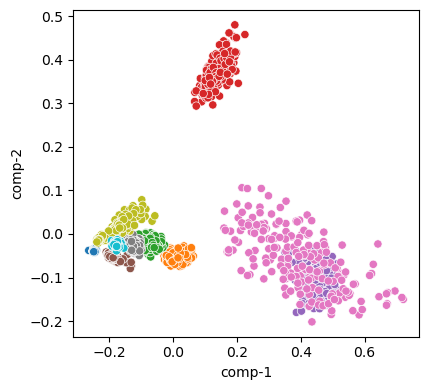

In [17]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
ax = sns.scatterplot(data=Xfactor_train_global[Xfactor_train_global['Condition']=='Source'],
                x = 0, y = 1, hue = 'Classe', 
                palette = "tab10")
ax.legend_.remove()
plt.xlabel('comp-1')
plt.ylabel('comp-2')
plt.tight_layout()
plt.savefig('./imagens/T{}{}_PCA_source_input.jpg'.format(src, tgt),
           dpi = 600)

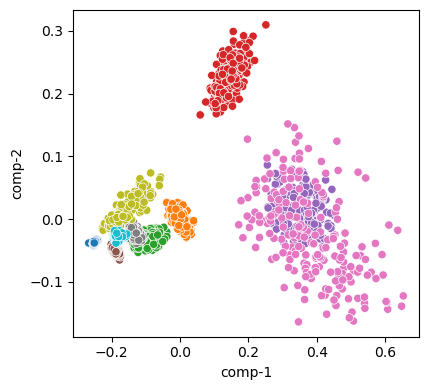

In [18]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
ax = sns.scatterplot(data=Xfactor_train_global[Xfactor_train_global['Condition']=='Target'],
                x = 0, y = 1, hue = 'Classe', 
                palette = "tab10")
ax.legend_.remove()
plt.xlabel('comp-1')
plt.ylabel('comp-2')
plt.tight_layout()
plt.savefig('./imagens/T{}{}_PCA_target_input.jpg'.format(src, tgt),
           dpi = 600)

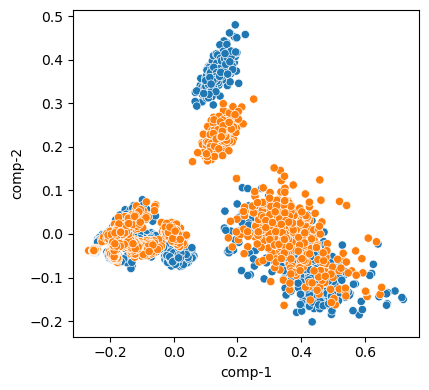

In [19]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
ax = sns.scatterplot(data=Xfactor_train_global,
                x = 0, y = 1, hue = 'Condition', 
                palette = "tab10")
ax.legend_.remove()
plt.xlabel('comp-1')
plt.ylabel('comp-2')
plt.tight_layout()
plt.savefig('./imagens/T{}{}_PCA_conditions_distribution_input.jpg'.format(src, tgt),
           dpi = 600)

In [20]:
fig = px.scatter_3d(Xfactor_train_global, x=0, y=1, z=2,
              color='Condition')
fig.show()

# TSNE 

In [21]:
from sklearn.manifold import TSNE

In [22]:
aux = np.append(data_src_fft.reshape(2000,512), data_tgt_fft.reshape(2000,512), axis = 0)
aux.shape

(4000, 512)

In [23]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(aux)
label_src

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.002s...
[t-SNE] Computed neighbors for 4000 samples in 0.283s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.018792
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.786652
[t-SNE] KL divergence after 1000 iterations: 0.888716


array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

In [24]:
yaux = np.append(label_src,label_tgt)

In [25]:
df = pd.DataFrame()
df["y"] = yaux
df["y2"] = 'Source'
df.loc[2000:, 'y2'] = 'Target'
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

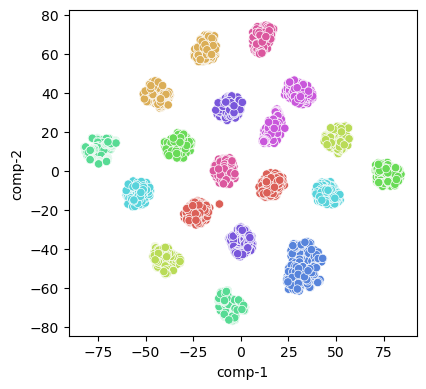

In [26]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df)
ax.legend_.remove()
plt.tight_layout()
plt.savefig('./imagens/T{}{}_tSNE_distribution_classes_input.jpg'.format(src, tgt),
           dpi = 600)

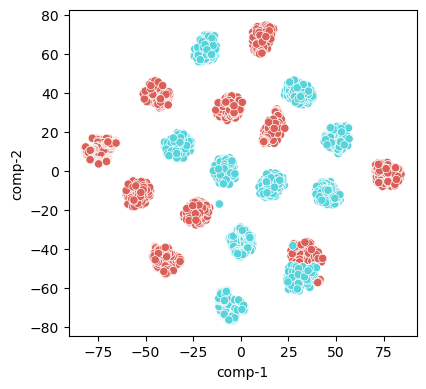

In [27]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y2.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df)
ax.legend_.remove()
plt.tight_layout()
plt.savefig('./imagens/T{}{}_tSNE_distribution_conditions_input.jpg'.format(src, tgt),
           dpi = 600)

# Base Line Model 

In [28]:
# train test Split
(data_src_fft_train, data_src_fft_test, 
label_src_train, label_src_test) = train_test_split(data_src_fft, label_src, test_size=0.33, random_state=42)
print(data_src_fft_train.shape,
        data_src_fft_test.shape,
        label_src_train.shape,
        label_src_test.shape)

(data_tgt_fft_train, data_tgt_fft_test, 
label_tgt_train, label_tgt_test) = train_test_split(data_tgt_fft, label_tgt, test_size=0.33, random_state=42)
print(data_tgt_fft_train.shape,
        data_tgt_fft_test.shape,
        label_tgt_train.shape,
        label_tgt_test.shape)

(1340, 512, 1) (660, 512, 1) (1340,) (660,)
(1340, 512, 1) (660, 512, 1) (1340,) (660,)


In [29]:
def feature_extractor(x):
    h = Conv1D(10, 3, padding='same', activation="relu")(x)
    h = Dropout(0.5)(h)
    h = Conv1D(10, 3, padding='same', activation="relu")(h)
    h = Dropout(0.5)(h)
    h = Conv1D(10, 3, padding='same', activation="relu")(h)
    h = Dropout(0.5)(h)
    h = Flatten()(h)
    h = Dense(256, activation='relu', name = 'feature')(h)
    return h

In [30]:
def clf(x):    
    h = Dense(256, activation='relu')(x)
    h = Dense(10, activation='softmax', name="clf")(h)
    return h

In [31]:
def baseline():
    input_dim = 512    
    inputs = Input(shape=(input_dim, 1))
    features = feature_extractor(inputs)
    logits = clf(features)
    baseline_model = Model(inputs=inputs, outputs=logits)
    adam = Adam(learning_rate=0.0001)
    baseline_model.compile(optimizer=adam,
              loss=['sparse_categorical_crossentropy'], metrics=['accuracy'])
    return baseline_model

In [64]:
# Set seed
accs_base_src = []
accs_base_tgt = []
#accs_base = []
import random as python_random
for i in range(10):
    python_random.seed(i)
    np.random.seed(i)
    tf.random.set_seed(i)
    baseline_model = baseline()
    # Run training 
    history_base = baseline_model.fit(data_src_fft_train, label_src_train,
                                      batch_size=128,
                                      epochs=1000,
                                      shuffle=True,
                                      verbose=False)
    # Run evaluating
    score, acc_src = baseline_model.evaluate(data_src_fft_test, label_src_test, batch_size=128)
    score, acc_tgt = baseline_model.evaluate(data_tgt_fft_test, label_tgt_test, batch_size=128)
    print("Accuracy for the baseline model on Source data is", acc_src)
    print("Accuracy for the baseline model on target data is", acc_tgt)
    accs_base_src.append(acc_src)
    accs_base_tgt.append(acc_tgt)
print("ten run mean", np.mean(accs_base_src))
print("ten run mean", np.mean(accs_base_tgt))

6/6 [==============================] - 0s 3ms/step - loss: 0.0352 - accuracy: 0.9848
Accuracy for the baseline model on Source data is 1.0
Accuracy for the baseline model on target data is 0.9848484992980957
6/6 [==============================] - 0s 2ms/step - loss: 0.0046 - accuracy: 0.9985
Accuracy for the baseline model on Source data is 1.0
Accuracy for the baseline model on target data is 0.9984848499298096
6/6 [==============================] - 0s 2ms/step - loss: 0.0151 - accuracy: 0.9970
Accuracy for the baseline model on Source data is 1.0
Accuracy for the baseline model on target data is 0.9969696998596191
6/6 [==============================] - 0s 3ms/step - loss: 0.0123 - accuracy: 0.9955
Accuracy for the baseline model on Source data is 1.0
Accuracy for the baseline model on target data is 0.9954545497894287
6/6 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.9970
Accuracy for the baseline model on Source data is 1.0
Accuracy for the baseline mod

In [65]:
np.savetxt("./logs/T{}{}_baseline.csv".format(src,tgt), np.array([accs_base_src, accs_base_tgt]), delimiter=";")
np.savetxt("./logs/T{}{}_mean_baseline.csv".format(src,tgt), np.array([np.mean(accs_base_src),
                                       np.mean(accs_base_tgt)]), delimiter=";")

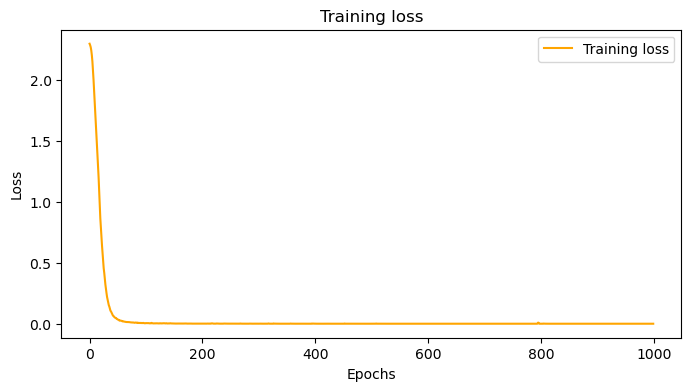

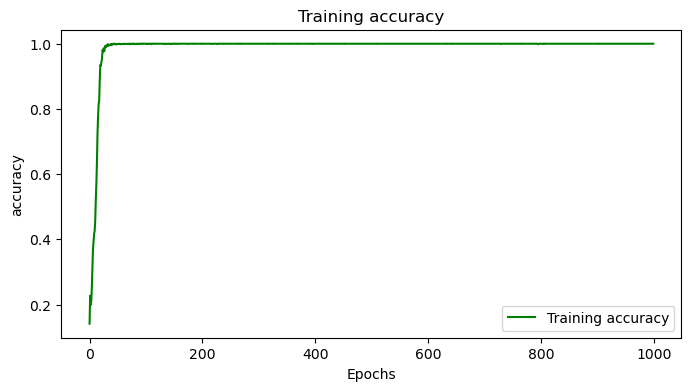

In [66]:
plt.figure(figsize=(8, 4))
plt.plot(history_base.epoch, history_base.history["loss"], 'orange', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history_base.epoch, history_base.history["accuracy"], 'g', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

63/63 [==============================] - 0s 3ms/step


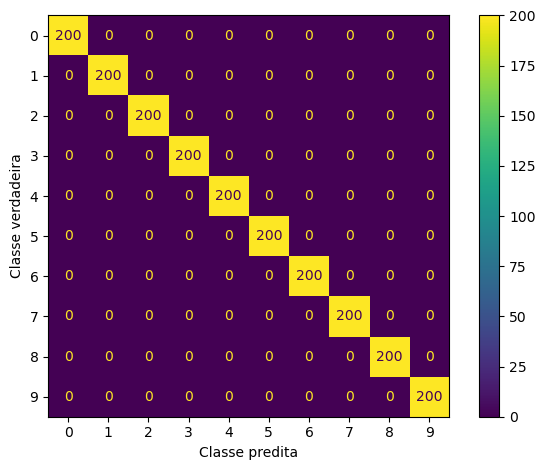

In [67]:
pred = baseline_model.predict(data_src_fft)
pred = [np.argmax(x) for x in pred]

cm = confusion_matrix(label_src, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=np.unique(label_tgt))
disp.plot()
plt.xlabel('Classe predita')
plt.ylabel('Classe verdadeira')
plt.tight_layout()
plt.savefig('./imagens/T{}{}_confusion matrix source validation Baseline.jpg'.format(src, tgt),
           dpi = 600)
plt.show()

63/63 [==============================] - 0s 3ms/step


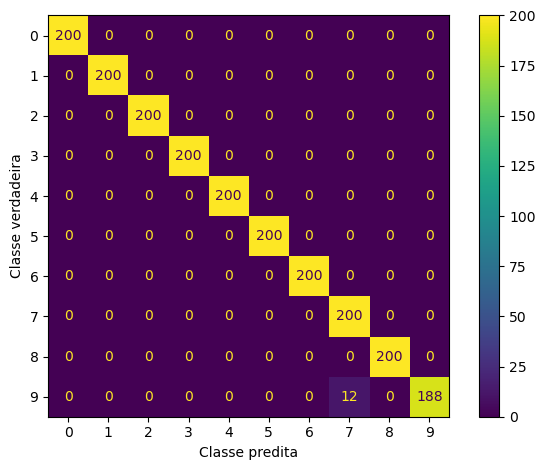

In [69]:
pred = baseline_model.predict(data_tgt_fft)
pred = [np.argmax(x) for x in pred]

cm = confusion_matrix(label_tgt, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=np.unique(label_tgt))
disp.plot()
plt.xlabel('Classe predita')
plt.ylabel('Classe verdadeira')
plt.tight_layout()
plt.savefig('./imagens/T{}{}_confusion matrix target validation Baseline.jpg'.format(src, tgt),
           dpi = 600)
plt.show()

# Gradient Reverse Layer(GRL) Layer

In [70]:
@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return grad_reverse(x)

In [71]:
def discriminator(x):    
    h = Dense(1024, activation='relu')(x)
    h = Dense(1024, activation='relu')(h)
    h = Dense(2, activation='softmax', name="dis")(h)
    return h

In [72]:
def grl():
    """ GRL strategy
    returns: the classification branch, the discriminator branch
    """
    input_dim = 512
    
    ### Define inputs
    inputs = Input(shape=(input_dim, 1))
    ### Get features
    features = feature_extractor(inputs)
    ### Get classification logits
    logits = clf(features)
    ### Define the classification branch model
    clf_branch = Model(inputs=inputs, outputs=logits)
    adam = Adam(learning_rate=0.0001)   
    clf_branch.compile(optimizer=adam,
              loss={'clf': 'sparse_categorical_crossentropy'}, metrics=['accuracy'])
    
    ### Define the classification branch model    
    features_rev = GradReverse()(features)
    logits_da = discriminator(features_rev)

    da_branch = Model(inputs=inputs, outputs=logits_da)
    adam_da = Adam(learning_rate=0.0001)   
    da_branch.compile(optimizer=adam_da,
              loss={'dis': 'sparse_categorical_crossentropy'}, metrics=['accuracy'])
    return clf_branch, da_branch

In [73]:
### Some constants
NUM_EPOCH = 1000
BATCH_SIZE = 128
DATASET_SIZE = 1340

accs_src = []
accs_tgt = []
history_tr = pd.DataFrame([], columns = ['loss', 'accuracy'])
history_val = pd.DataFrame([], columns = ['loss', 'accuracy'])

import random as python_random

for i in range(10):
    
    python_random.seed(i)
    np.random.seed(i)
    tf.random.set_seed(i)
    clf_branch, da_branch = grl()
    
    ### Iterate over 
    #for j in range(NUM_EPOCH * (DATASET_SIZE // BATCH_SIZE)):
    for j in range(NUM_EPOCH):
        
        ### Randomly fetch training data
        idx_src = np.random.choice(DATASET_SIZE, size=BATCH_SIZE, replace=False)
        idx_tgt = np.random.choice(DATASET_SIZE, size=BATCH_SIZE, replace=False)
        batch_src, batch_y = data_src_fft_train[idx_src], label_src_train[idx_src]
        
        ### We don't use any label from target domain
        batch_tgt = data_tgt_fft_train[idx_tgt] 
        
        ########## the training code for clf_branch ###################
        result = clf_branch.train_on_batch(batch_src, batch_y)
        result = clf_branch.evaluate(data_src_fft_test, label_src_test, batch_size=128, verbose = False)
        history_tr = pd.concat([history_tr, pd.DataFrame([result], columns = ['loss', 'accuracy'])])
        
        result = clf_branch.evaluate(data_tgt_fft_test, label_tgt_test, batch_size=128, verbose = False)
        history_val = pd.concat([history_val, pd.DataFrame([result], columns = ['loss', 'accuracy'])])
        
        ########## the training code for discriminator branch #########
        dis_y = np.concatenate([np.zeros_like(batch_y), np.ones_like(batch_y)], axis=0)
        da_branch.train_on_batch(np.concatenate([batch_src, batch_tgt], axis=0), dis_y)

    ### Final results
    score, acc_src = clf_branch.evaluate(data_src_fft_test, label_src_test, batch_size=128)
    score, acc_tgt = clf_branch.evaluate(data_tgt_fft_test, label_tgt_test, batch_size=128)
    print("Final Accuracy src", acc_src)
    print("Final Accuracy tgt", acc_tgt)
    accs_src.append(acc_src)
    accs_tgt.append(acc_tgt)
    
history_tr.reset_index(inplace = True, drop = True)
history_val.reset_index(inplace = True, drop = True)
print("ten run mean src", np.mean(accs_src))
print("ten run mean tgt", np.mean(accs_tgt))

np.savetxt("./logs/T{}{}_DANN.csv".format(src,tgt), np.array([accs_src, accs_tgt]), delimiter=";")
np.savetxt("./logs/T{}{}_mean_DANN.csv".format(src,tgt), np.array([np.mean(accs_src),
                                                                    np.mean(accs_tgt)]), delimiter=";")

6/6 [==============================] - 0s 4ms/step - loss: 0.0243 - accuracy: 1.0000
Final Accuracy src 1.0
Final Accuracy tgt 1.0
6/6 [==============================] - 0s 4ms/step - loss: 0.0213 - accuracy: 1.0000
Final Accuracy src 1.0
Final Accuracy tgt 1.0
6/6 [==============================] - 0s 4ms/step - loss: 0.0224 - accuracy: 1.0000
Final Accuracy src 1.0
Final Accuracy tgt 1.0
6/6 [==============================] - 0s 4ms/step - loss: 0.0148 - accuracy: 1.0000
Final Accuracy src 1.0
Final Accuracy tgt 1.0
6/6 [==============================] - 0s 3ms/step - loss: 0.0207 - accuracy: 1.0000
Final Accuracy src 1.0
Final Accuracy tgt 1.0
6/6 [==============================] - 0s 4ms/step - loss: 0.0186 - accuracy: 1.0000
Final Accuracy src 1.0
Final Accuracy tgt 1.0
6/6 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.9939
Final Accuracy src 1.0
Final Accuracy tgt 0.9939393997192383
6/6 [==============================] - 0s 3ms/step - loss: 0.0357 - 

In [76]:
stats.ttest_ind(accs_base_tgt, accs_tgt)

Ttest_indResult(statistic=-3.179221970811104, pvalue=0.005194301068809507)

In [78]:
np.savetxt("./logs/T{}{}_test_t.csv".format(src,tgt), np.array(stats.ttest_ind(accs_base_tgt, accs_tgt)), delimiter=";")

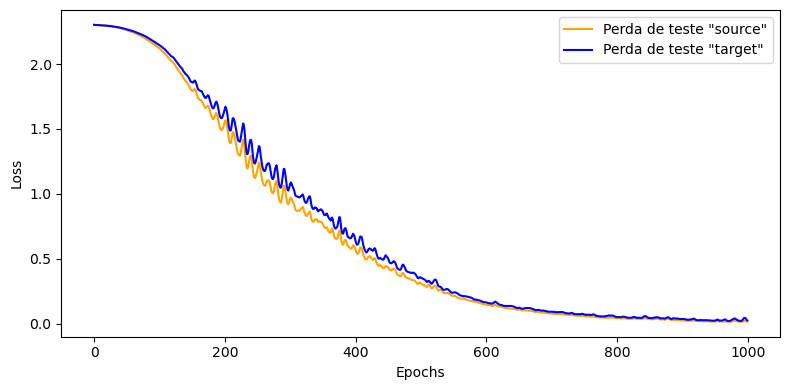

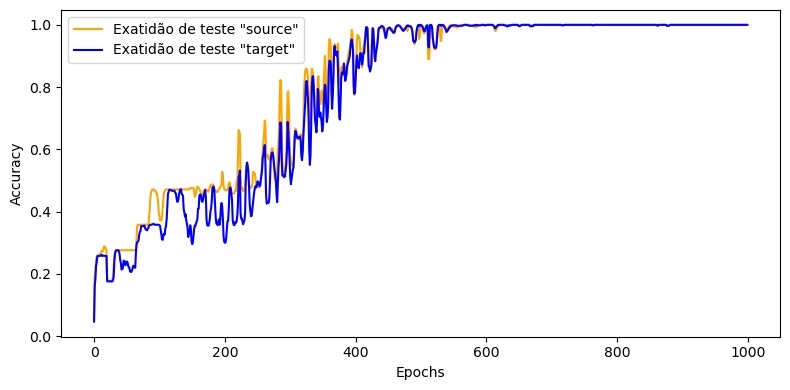

In [79]:
plt.figure(figsize=(8, 4))
#plt.subplot(2,1,1)
plt.plot(history_tr.index[0:1000], history_tr["loss"][0:1000], 'orange', label='Perda de teste "source"')
plt.plot(history_val.index[0:1000], history_val["loss"][0:1000], 'b', label='Perda de teste "target"')
#plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('./imagens/T{}{}_epochs_loss.jpg'.format(src, tgt),
           dpi = 600)
plt.show()

plt.figure(figsize=(8, 4))
#plt.subplot(2,1,2)
plt.plot(history_tr.index[0:1000], history_tr["accuracy"][0:1000], 'orange', label='Exatidão de teste "source"')
plt.plot(history_val.index[0:1000], history_val["accuracy"][0:1000], 'b', label='Exatidão de teste "target"')
#plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('./imagens/T{}{}_epochs_accuracy.jpg'.format(src, tgt),
           dpi = 600)
plt.show()

63/63 [==============================] - 0s 4ms/step


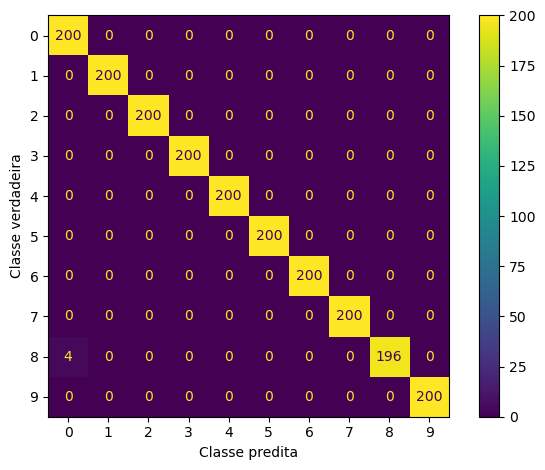

In [80]:
pred = clf_branch.predict(data_src_fft)
pred = [np.argmax(x) for x in pred]

cm = confusion_matrix(label_tgt, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=np.unique(label_tgt))
disp.plot()
plt.xlabel('Classe predita')
plt.ylabel('Classe verdadeira')
plt.tight_layout()
plt.savefig('./imagens/T{}{}_confusion matrix source validation DANN.jpg'.format(src, tgt),
           dpi = 600)
plt.show()

63/63 [==============================] - 0s 3ms/step


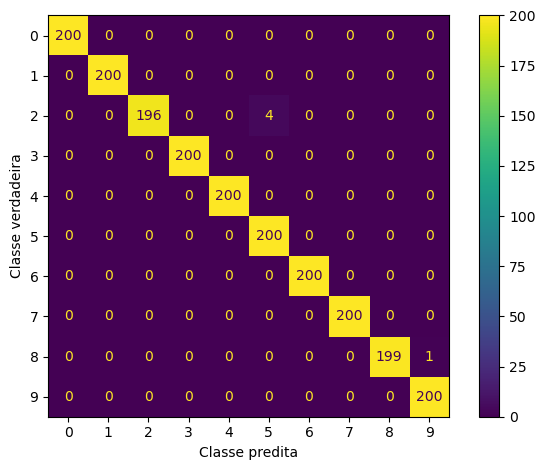

In [81]:
pred = clf_branch.predict(data_tgt_fft)
pred = [np.argmax(x) for x in pred]

cm = confusion_matrix(label_tgt, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=np.unique(label_tgt))
disp.plot()
plt.xlabel('Classe predita')
plt.ylabel('Classe verdadeira')
plt.tight_layout()
plt.savefig('./imagens/T{}{}_confusion matrix target validation DANN.jpg'.format(src, tgt),
           dpi = 600)
plt.show()

# Feature Factors 

In [82]:
clf_branch.summary()

Model: "model_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 512, 1)]          0         
                                                                 
 conv1d_117 (Conv1D)         (None, 512, 10)           40        
                                                                 
 dropout_117 (Dropout)       (None, 512, 10)           0         
                                                                 
 conv1d_118 (Conv1D)         (None, 512, 10)           310       
                                                                 
 dropout_118 (Dropout)       (None, 512, 10)           0         
                                                                 
 conv1d_119 (Conv1D)         (None, 512, 10)           310       
                                                                 
 dropout_119 (Dropout)       (None, 512, 10)           0  

In [83]:
feature_output = Model(clf_branch.input, clf_branch.get_layer('feature').output)

In [84]:
feture_pred = feature_output(data_src_fft)
feture_pred.shape

TensorShape([2000, 256])

In [85]:
feture_pred_tgt = feature_output(data_tgt_fft)
feture_pred_tgt

<tf.Tensor: shape=(2000, 256), dtype=float32, numpy=
array([[2.3867507 , 0.2793974 , 0.00469145, ..., 2.4458163 , 2.3112495 ,
        0.5095995 ],
       [2.4199305 , 0.35889277, 0.06581964, ..., 2.431497  , 2.3011584 ,
        0.6349756 ],
       [2.4047937 , 0.3553429 , 0.05522213, ..., 2.4541018 , 2.3291147 ,
        0.63532615],
       ...,
       [2.0383773 , 0.9088878 , 0.61838275, ..., 2.6113415 , 2.370024  ,
        0.70223457],
       [2.055755  , 0.923638  , 0.6396937 , ..., 2.594291  , 2.3676257 ,
        0.7129782 ],
       [2.0522459 , 0.9072702 , 0.6281538 , ..., 2.6003776 , 2.3731568 ,
        0.70151407]], dtype=float32)>

# PCA

In [86]:
pca = PCA(n_components=7)
pca_model = pca.fit(np.array(feture_pred))
Xfactor_train_source = pca_model.transform(np.array(feture_pred))
Xfactor_train_target = pca_model.transform(np.array(feture_pred_tgt))

In [87]:
Xfactor_source = pd.DataFrame(Xfactor_train_source).reset_index(drop=True)
Xfactor_target = pd.DataFrame(Xfactor_train_target).reset_index(drop=True)
y_train_source = pd.DataFrame(label_src).reset_index(drop=True)
y_train_source['Condition']='Source'
Xfactor_source[['Label', 'Condition']]= y_train_source
y_train_target = pd.DataFrame(label_tgt).reset_index(drop=True)
y_train_target['Condition']='Target'
Xfactor_target[['Label', 'Condition']]= y_train_target

In [88]:
Xfactor_train_global = pd.concat([Xfactor_source, Xfactor_target])
Xfactor_train_global.reset_index(inplace=True, drop=True)
Xfactor_train_global

0         1         2         3         4         5         6  \
0    -10.370466 -0.987487  0.061702 -0.100513  0.661673 -0.258901 -0.217900   
1     -9.695396 -1.254488 -0.377708 -0.179092  0.849117 -0.002378 -0.274668   
2     -9.728924 -1.341735 -0.386450 -0.174803  0.865592 -0.076115 -0.266640   
3     -9.604576 -1.402642 -0.498299 -0.208878  0.899346 -0.034660 -0.288457   
4     -9.793133 -1.255906 -0.392427 -0.191960  0.873366 -0.061962 -0.279401   
...         ...       ...       ...       ...       ...       ...       ...   
3995  -6.907245  0.289918  0.699232  0.466030 -0.221989 -0.101085 -0.082738   
3996  -6.800735  0.241612  0.605699  0.461327 -0.258780 -0.017213 -0.153556   
3997  -6.801519  0.742261  0.624186  0.516062 -0.231865  0.132143 -0.085535   
3998  -6.476812  0.593277  0.763581  0.533103 -0.258470 -0.007989 -0.106664   
3999  -6.668208  0.658853  0.750548  0.532969 -0.241983  0.003477 -0.057259   

      Label Condition  
0         0    Source  
1         0    Source  
2         0    Source  
3         0    Source  
4         0    Source  
...     ...       ...  
3995      9    Target  
3996      9    Target  
3997      9    Target  
3998      9    Target  
3999      9    Target  

[4000 rows x 9 columns]

In [89]:
print(
    "explained variance ratio (first two components): %s"
    % str(pca_model.explained_variance_ratio_)
)

explained variance ratio (first two components): [0.8297322  0.11462709 0.0376607  0.01057182 0.00338675 0.00156489
 0.00104495]


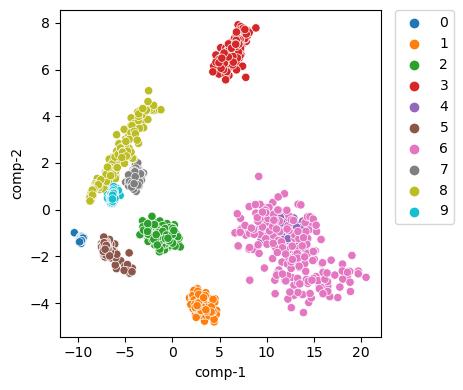

In [90]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
ax = sns.scatterplot(data=Xfactor_train_global[Xfactor_train_global['Condition']=='Source'],
                x = 0, y = 1, hue = 'Label', 
                palette = "tab10")
ax.legend(loc = 'upper right',
         bbox_to_anchor=(1.25, 1.02))
plt.xlabel('comp-1')
plt.ylabel('comp-2')
plt.tight_layout()
plt.savefig('./imagens/T{}{}_PCA_source_feature.jpg'.format(src, tgt),
           dpi = 600)

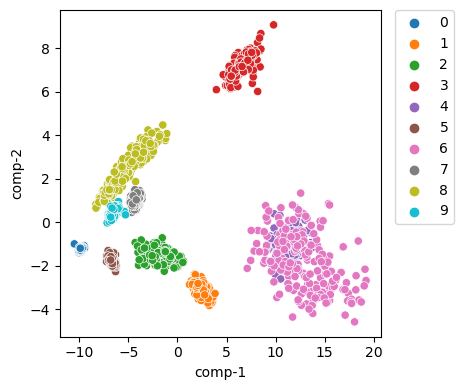

In [91]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
ax = sns.scatterplot(data=Xfactor_train_global[Xfactor_train_global['Condition']=='Target'],
                x = 0, y = 1, hue = 'Label', 
                palette = "tab10")
ax.legend(loc = 'upper right',
         bbox_to_anchor=(1.25, 1.02))
plt.xlabel('comp-1')
plt.ylabel('comp-2')
plt.tight_layout()
plt.savefig('./imagens/T{}{}_PCA_target_feature.jpg'.format(src, tgt),
           dpi = 600)

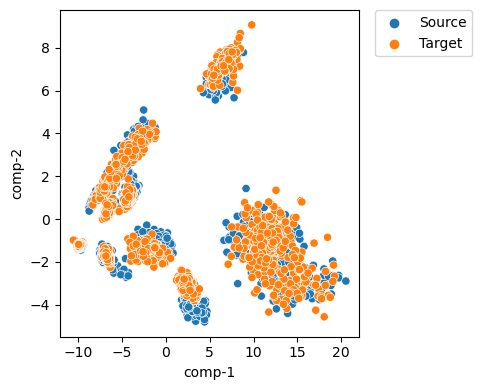

In [92]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
ax = sns.scatterplot(data=Xfactor_train_global,
                x = 0, y = 1, hue = 'Condition', 
                palette = "tab10")
ax.legend(loc = 'upper right',
         bbox_to_anchor=(1.4, 1.02))
plt.xlabel('comp-1')
plt.ylabel('comp-2')
plt.tight_layout()
plt.savefig('./imagens/T{}{}_PCA_conditions_distribution_feature.jpg'.format(src, tgt),
           dpi = 600)

In [93]:
fig = px.scatter_3d(Xfactor_train_global, x=0, y=1, z=2,
              color='Condition')
fig.show()

# TSNE

In [94]:
aux = np.append(np.array(feture_pred),np.array(feture_pred_tgt),axis=0)
aux.shape

(4000, 256)

In [95]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(aux)
label_src

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.001s...
[t-SNE] Computed neighbors for 4000 samples in 0.262s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.124604
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.820084
[t-SNE] KL divergence after 1000 iterations: 0.587869


array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

In [96]:
yaux = np.append(label_src,label_tgt)

In [97]:
df = pd.DataFrame()
df["y"] = yaux
df["y2"] = 'Source'
df.loc[2000:, 'y2'] = 'Target'
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

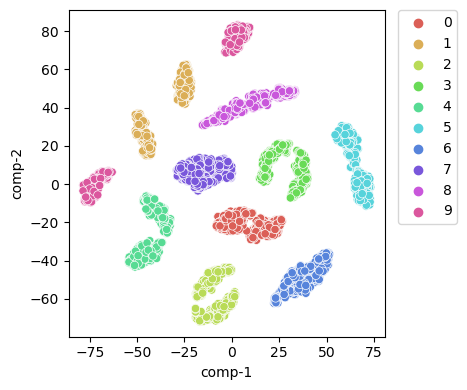

In [98]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df)
ax.legend(loc = 'upper right',
         bbox_to_anchor=(1.25, 1.02))
plt.tight_layout()
plt.savefig('./imagens/T{}{}_tSNE_distribution_classes_feature.jpg'.format(src, tgt),
           dpi = 600)

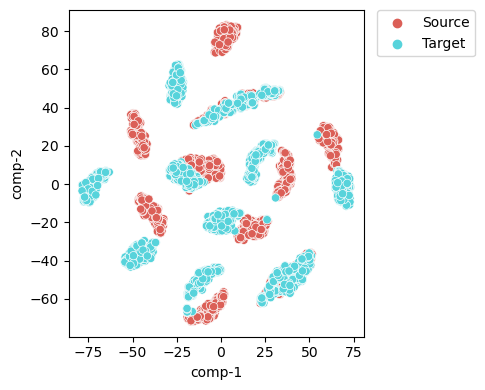

In [99]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
ax = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y2.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df)
ax.legend(loc = 'upper right',
         bbox_to_anchor=(1.4, 1.02))
plt.tight_layout()
plt.savefig('./imagens/T{}{}_tSNE_distribution_conditions_feature.jpg'.format(src, tgt),
           dpi = 600)

# Confusion Matrix, Precision and Recall

In [ ]:
#https://github.com/kashyaprakshith/Domain_Adaptation_Bosch_Rexroth/blob/main/CWRU_Domain_Adaptation.ipynb

In [ ]:
target_domain=target_data_a.float()
target_labels=target_labels_a.long()
target_domain=target_data_b.float()
target_labels=target_labels_b.long()
target_domain=target_data_c.float()
target_labels=target_labels_c.long()
# target_domain=source_data.float()
# target_labels=source_labels_0.long()

eval_tgt(src_encoder, src_classifier)
x,y=eval_tgt(tgt_encoder, src_classifier)

from sklearn.metrics import confusion_matrix
import pandas as pd

pred = torch.LongTensor(2816, 5).cuda()
torch.cat(x, out=pred)

actual = torch.LongTensor(2816, 5).cuda()
torch.cat(y, out=actual)

pred=pred.cpu()
actual=actual.cpu()
con= confusion_matrix(actual.numpy(),pred.numpy(),labels=[0,1,2,3,4,5,6,7,8,9])
recall = np.diag(con) / np.sum(con, axis = 1)
precision = np.diag(con) / np.sum(con, axis = 0)
avg_recall=np.mean(recall)*100
avg_precision=np.mean(precision)*100
f_measure= 2*(avg_recall*avg_precision)/(avg_precision+avg_recall)
con = con.astype('float') / con.sum(axis=1)[:, np.newaxis]
conf = pd.DataFrame(data=con)
conf.columns.name = 'Predicted label'
conf.index.name = 'Actual label'
print('precision:', avg_precision, 'recall:' , avg_recall, 'f-measure',f_measure)
conf

In [ ]:

con= confusion_matrix(actual.numpy(),pred.numpy(),labels=[0,1,2,3,4,5,6,7,8,9])
recall = np.diag(con) / np.sum(con, axis = 1)
precision = np.diag(con) / np.sum(con, axis = 0)
avg_recall=np.mean(recall)*100
avg_precision=np.mean(precision)*100
f_measure= 2*(avg_recall*avg_precision)/(avg_precision+avg_recall)
con = con.astype('float') / con.sum(axis=1)[:, np.newaxis]
conf = pd.DataFrame(data=con)
conf.columns.name = 'Predicted label'
conf.index.name = 'Actual label'
print('precision:', avg_precision, 'recall:' , avg_recall, 'f-measure',f_measure)
conf

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
pred = clf_branch.predict(data_src_fft)
pred = [np.argmax(x) for x in pred]

cm = confusion_matrix(label_tgt, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=np.unique(label_tgt))
disp.plot()
plt.show()

In [ ]:
pred = clf_branch.predict(data_src_fft)
#pred = [np.argmax(x) for x in pred]
pred

In [ ]:
pred = clf_branch.predict(data_src_fft)
pred = [np.argmax(x) for x in pred]

cm = confusion_matrix(label_src, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=np.unique(label_tgt))
disp.plot()
plt.show()

# End